In [74]:
!pip install --quiet kagglehub pandas matplotlib seaborn tqdm spacy nltk scikit-learn xgboost
# !pip install gensim
!python -m spacy download en_core_web_sm

/home/vdubyna/miniconda3/envs/ai/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import spacy
from tqdm.auto import tqdm
import kagglehub
import os
import re
import nltk
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    PrecisionRecallDisplay,
    f1_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/home/vdubyna/miniconda3/envs/ai/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [25]:
nltk.download('stopwords')
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vdubyna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Download latest version
path = kagglehub.dataset_download("shantanudhakadd/email-spam-detection-dataset-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/vdubyna/.cache/kagglehub/datasets/shantanudhakadd/email-spam-detection-dataset-classification/versions/1


In [5]:
df = pd.read_csv(os.path.join(path, 'spam.csv'), encoding='latin1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [6]:
df = df[['v2', 'v1']].copy()
df = df.rename(columns={'v2': 'message', 'v1': 'target'})
df

,message,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [7]:
# --- 1. Перевірка на пропущені значення ---
print("--- 1. Пропущені значення ---")
missing_values = df.isnull().sum()
print("Кількість пропущених значень по стовпцях:")
print(missing_values)

if df.isnull().any().any():
    print("\nУвага: У DataFrame є пропущені значення!")
else:
    print("\nПропущених значень у DataFrame не виявлено.")
print("-" * 50)

--- 1. Пропущені значення ---
Кількість пропущених значень по стовпцях:
message    0
target     0
dtype: int64

Пропущених значень у DataFrame не виявлено.
--------------------------------------------------


In [43]:
# --- 2. Перевірка дублікатів по стовпцю 'message' ---
print("\n--- 2. Дублікати у стовпці 'message' ---")
num_duplicate_messages = df['message'].duplicated().sum()
print(f"Кількість дубльованих повідомлень (перше входження не рахується): {num_duplicate_messages}")

if num_duplicate_messages > 0:
    print(f"Загальна кількість рядків, які є дублікатами за змістом 'message' (включаючи всі входження): {df[df['message'].duplicated(keep=False)].shape[0]}")
print("-" * 50)

# --- Видалення дублікатів по колонці 'message' ---
df = df.drop_duplicates(subset='message', keep='first').reset_index(drop=True)


--- 2. Дублікати у стовпці 'message' ---
Кількість дубльованих повідомлень (перше входження не рахується): 403
Загальна кількість рядків, які є дублікатами за змістом 'message' (включаючи всі входження): 684
--------------------------------------------------



--- 3. Баланс класів у стовпці 'target' ---
Абсолютна кількість значень по класах:
target
ham     4516
spam     653
Name: count, dtype: int64

Відсоткове співвідношення класів:
target
ham     87.366996
spam    12.633004
Name: proportion, dtype: float64


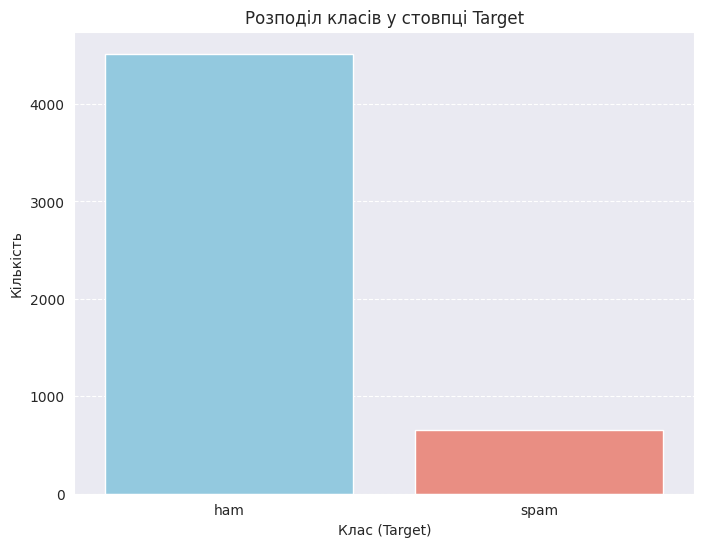

--------------------------------------------------

--- 4. Аналіз довжини повідомлень ---

Описова статистика для довжини повідомлень:
count    5169.000000
mean       78.977945
std        58.236293
min         2.000000
25%        36.000000
50%        60.000000
75%       117.000000
max       910.000000
Name: message_length, dtype: float64

Повідомлення розділені на 10 бакетів за довжиною.

Розподіл класів за бакетами довжини повідомлень:
target           ham  spam
length_bucket             
(1.092, 92.8]   3428    64
(92.8, 183.6]    965   587
(183.6, 274.4]    74     2
(274.4, 365.2]    30     0
(365.2, 456.0]    11     0
(456.0, 546.8]     3     0
(546.8, 637.6]     3     0
(637.6, 728.4]     0     0
(728.4, 819.2]     1     0
(819.2, 910.0]     1     0


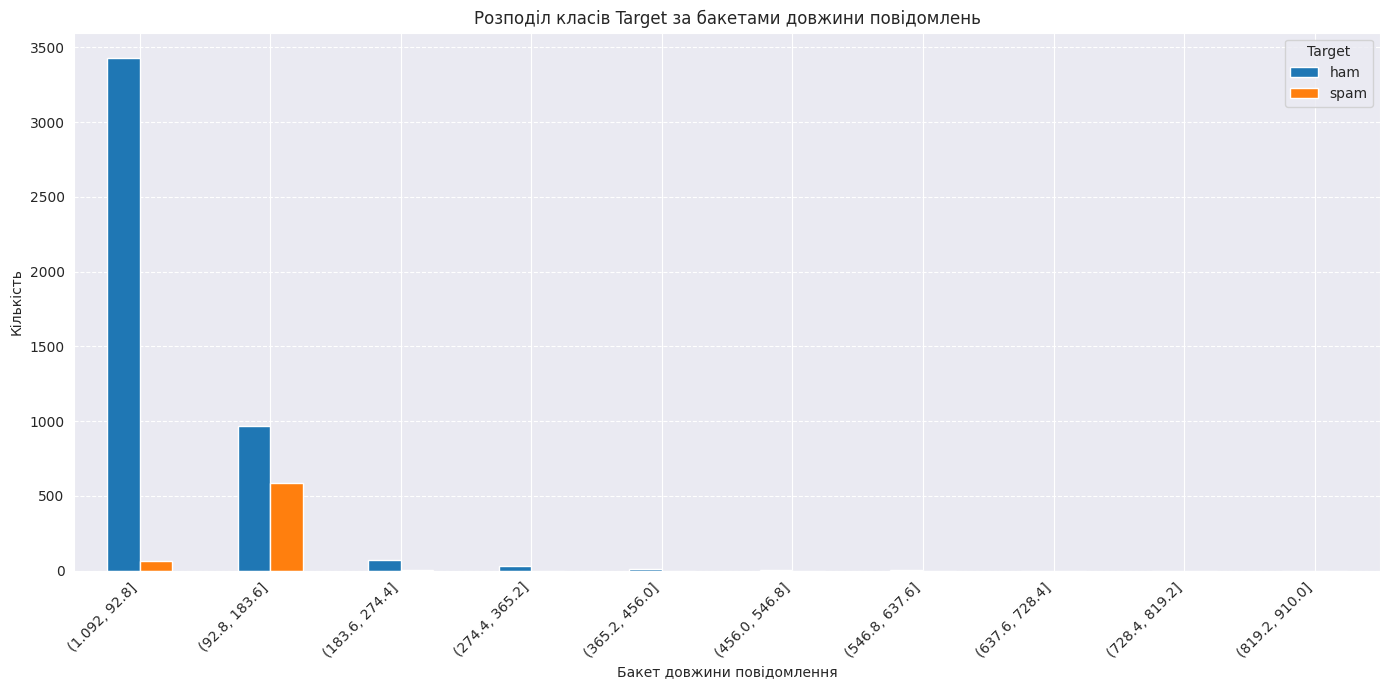

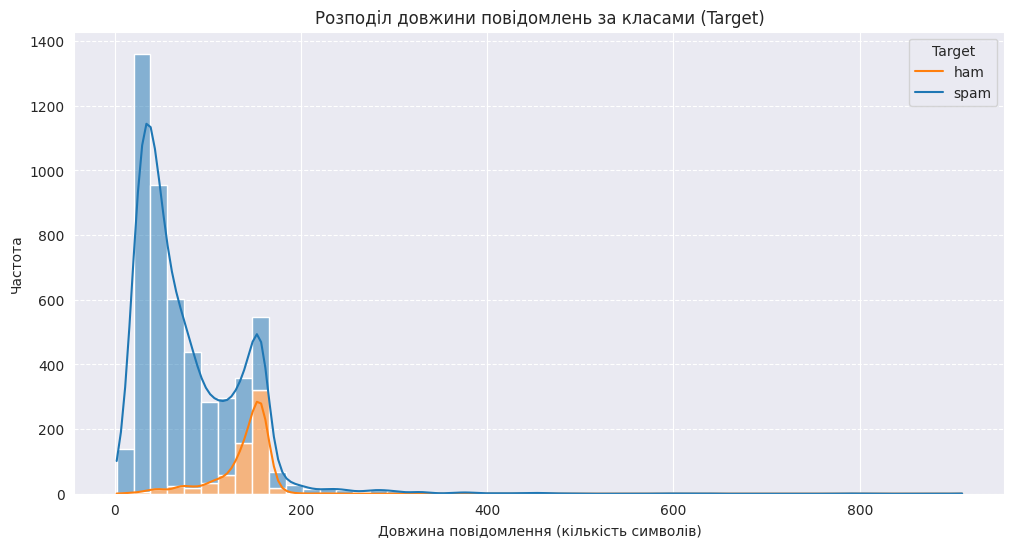

--------------------------------------------------


In [44]:
# --- 3. Баланс класів у стовпці 'target' ---
print("\n--- 3. Баланс класів у стовпці 'target' ---")
target_counts = df['target'].value_counts()
target_percentages = df['target'].value_counts(normalize=True) * 100

print("Абсолютна кількість значень по класах:")
print(target_counts)
print("\nВідсоткове співвідношення класів:")
print(target_percentages)

# Візуалізація балансу класів
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='target', hue='target', palette={'ham': 'skyblue', 'spam': 'salmon'}, legend=False)
plt.title('Розподіл класів у стовпці Target')
plt.xlabel('Клас (Target)')
plt.ylabel('Кількість')
plt.grid(axis='y', linestyle='--')
plt.show()
print("-" * 50)

# --- 4. Аналіз довжини повідомлень (кількість символів) ---
print("\n--- 4. Аналіз довжини повідомлень ---")
df['message_length'] = df['message'].apply(len)

print("\nОписова статистика для довжини повідомлень:")
print(df['message_length'].describe())

# Розділення на бакети (bins)
# Ви можете налаштувати кількість бакетів або конкретні межі
num_bins = 10 # Наприклад, 10 бакетів
try:
    df['length_bucket'] = pd.cut(df['message_length'], bins=num_bins)
    print(f"\nПовідомлення розділені на {num_bins} бакетів за довжиною.")

    # Порахувати кількість класів у кожному бакеті
    length_bucket_target_counts = df.groupby(['length_bucket', 'target'], observed=False).size().unstack(fill_value=0)
    # observed=False важливо для pd.cut, щоб показати всі бакети, навіть порожні для деяких комбінацій

    print("\nРозподіл класів за бакетами довжини повідомлень:")
    print(length_bucket_target_counts)

    # Візуалізація у вигляді стовпчастої діаграми
    length_bucket_target_counts.plot(kind='bar', stacked=False, figsize=(14, 7)) # stacked=False для групованих стовпчиків, stacked=True для складених
    plt.title('Розподіл класів Target за бакетами довжини повідомлень')
    plt.xlabel('Бакет довжини повідомлення')
    plt.ylabel('Кількість')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Target')
    plt.tight_layout() # Для кращого розміщення елементів
    plt.grid(axis='y', linestyle='--')
    plt.show()

except ValueError as e:
    print(f"\nПомилка при створенні бакетів: {e}")
    print("Це може статися, якщо всі значення довжини однакові або діапазон дуже малий.")
    print("Спробуйте змінити кількість бакетів або перевірити різноманітність значень 'message_length'.")


# Гістограма розподілу довжини повідомлень для кожного класу
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='message_length', hue='target', multiple="stack", kde=True, bins=50) # bins можна налаштувати
plt.title('Розподіл довжини повідомлень за класами (Target)')
plt.xlabel('Довжина повідомлення (кількість символів)')
plt.ylabel('Частота')
plt.legend(title='Target', labels=df['target'].unique()) # переконайтесь, що мітки відповідають
plt.grid(axis='y', linestyle='--')
plt.show()
print("-" * 50)


In [45]:
contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

In [46]:
# Stop-words
stop_words = set(stopwords.words('english')).union({'also', 'would', 'much', 'many'})

negations = {
    'aren',
    "aren't",
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'isn',
    "isn't",
    'mightn',
    "mightn't",
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'no',
    'nor',
    'not',
    'shan',
    "shan't",
    'shouldn',
    "shouldn't",
    'wasn',
    "wasn't",
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't"
}

stop_words = stop_words.difference(negations)

In [47]:
# removing negations from the stop-words list
stop_words = stop_words.difference(negations)

In [48]:
stemmer = PorterStemmer()

In [49]:
nlp = spacy.load("en_core_web_sm", disable = ['parser','ner'])

In [50]:
# function to clean text
def normalize_text(raw_review):

    # Remove html tags
    text = re.sub("<[^>]*>", " ", raw_review) # match <> and everything in between. [^>] - match everything except >

    # Remove emails
    text = re.sub("\S*@\S*[\s]+", " ", text) # match non-whitespace characters, @ and a whitespaces in the end

    # remove links
    text = re.sub("https?:\/\/.*?[\s]+", " ", text) # match http, s - zero or once, //,
                                                    # any char 0-unlimited, whitespaces in the end

     # Convert to lower case, split into individual words
    text = text.lower().split()

    # Replace contractions with their full versions
    text = [contractions.get(word) if word in contractions else word
            for word in text]

    # Re-splitting for the correct stop-words extraction
    text = " ".join(text).split()

    # Remove stop words
    text = [word for word in text if not word in stop_words]

    text = " ".join(text)

    # Remove non-letters
    text = re.sub("[^a-zA-Z' ]", "", text) # match everything except letters and '


    # Stem words. Need to define porter stemmer above
    # text = [stemmer.stem(word) for word in text.split()]

    # Lemmatize words. Need to define lemmatizer above
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc if len(token.lemma_) > 1 ])

    # Remove excesive whitespaces
    text = re.sub("[\s]+", " ", text)

    # Join the words back into one string separated by space, and return the result.
    return text

In [51]:
text = df['message'].sample()
text

575    So how's scotland. Hope you are not over showi...
Name: message, dtype: object

In [52]:
text = df['message'].sample().item()
print('Original text', text, '#'*30, sep='\n\n')
print('\nNormalized text', normalize_text(text), sep='\n\n')

Original text

Aight what time you want me to come up?

##############################

Normalized text

aight time want come up


In [53]:
df['message_normalized'] = df['message'].progress_apply(normalize_text)
df

  0%|          | 0/5169 [00:00<?, ?it/s]

,message,target,message_length,length_bucket,target_numeric,message_normalized
0,"Go until jurong point, crazy.. Available only ...",ham,111,"(92.8, 183.6]",0,go jurong point crazy available bugis great wo...
1,Ok lar... Joking wif u oni...,ham,29,"(1.092, 92.8]",0,ok lar joke wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155,"(92.8, 183.6]",1,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,ham,49,"(1.092, 92.8]",0,dun say early hor already say
4,"Nah I don't think he goes to usf, he lives aro...",ham,61,"(1.092, 92.8]",0,nah not think go usf live around though
...,...,...,...,...,...,...
5164,This is the 2nd time we have tried 2 contact u...,spam,161,"(92.8, 183.6]",1,nd time try contact win pound prize claim easy...
5165,Will Ì_ b going to esplanade fr home?,ham,37,"(1.092, 92.8]",0,go esplanade fr home
5166,"Pity, * was in mood for that. So...any other s...",ham,57,"(1.092, 92.8]",0,pity mood that soany suggestion
5167,The guy did some bitching but I acted like i'd...,ham,125,"(92.8, 183.6]",0,guy bitching act like interested buy something...


In [54]:
# Кодуєм лейбли для метрик
df['target_numeric'] = df['target'].map({'ham': 0, 'spam': 1})

In [55]:
X = df['message_normalized']
y = df['target_numeric']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,    # Частка даних для валідаційного набору (20%)
    random_state=42,  # Для відтворюваності результатів
    stratify=y        # Важливо для збереження пропорцій класів (якщо y - категоріальна)
                      # Якщо y не підходить для стратифікації (напр. багато унікальних значень або не категоріальна),
                      # цей параметр можна прибрати або y має бути відповідним чином підготовлений.
)
# Важливо перетворити в датафрейми щоб потім не було помилок
X_train = pd.DataFrame({'message_normalized': X_train})
X_test = pd.DataFrame({'message_normalized': X_test})

In [57]:
print(f"Розмір X_train: {X_train.shape}")
print(f"Розмір X_test: {X_test.shape}")
print(f"Розмір y_train: {y_train.shape}")
print(f"Розмір y_test: {y_test.shape}")

print("\nПерші 5 прикладів X_train:")
print(X_train.head())
print("\nПерші 5 прикладів y_train:")
print(y_train.head())

Розмір X_train: (4135, 1)
Розмір X_test: (1034, 1)
Розмір y_train: (4135,)
Розмір y_test: (1034,)

Перші 5 прикладів X_train:
                                     message_normalized
331                 cool come have not wine dine before
383                                  huh late fr dinner
574                exwife not able kid want kid one day
1346  hope ur head not hurt plough way pile ironing ...
1070                               ryder unsoldnow gibb

Перші 5 прикладів y_train:
331     0
383     0
574     0
1346    0
1070    0
Name: target_numeric, dtype: int64


In [58]:
# Визначення препроцесора для ColumnTransformer
# Перший елемент - назва трансформації, другий - сам трансформер, третій - стовпці, до яких застосовується
preprocessor_tfidf = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'message_normalized'), # Трансформація для текстового стовпця
    ],
    remainder='passthrough' # Залишити інші стовпці (якщо є) без змін
)
preprocessor_cv = ColumnTransformer(
    transformers=[
        ('countvec', CountVectorizer(), 'message_normalized'), # Трансформація для текстового стовпця 'message_normalized'
    ],
    remainder='passthrough' # Залишити інші стовпці (якщо вони є) без змін
)

In [59]:

# --- Логістична регресія + TfidfVectorizer ---
pipe_logreg_tfid = Pipeline([
    ('preprocessor', preprocessor_tfidf),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))
])
param_grid_logreg_tfid = {
    'preprocessor__tfidf__max_features': [None, 500, 1000],
    'preprocessor__tfidf__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.1],
    'classifier__class_weight': ['balanced', None]
}

# --- Логістична регресія + CountVectorizer ---
pipe_logreg_cv = Pipeline([
    ('preprocessor', preprocessor_cv),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))
])

param_grid_logreg_cv = {
    'preprocessor__countvec__max_features': [None, 500, 1000],
    'preprocessor__countvec__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.1],
    'classifier__class_weight': ['balanced', None]
}

In [60]:
SCORING_METRIC = 'roc_auc' # або 'f1_weighted'
results = {} # Словник для зберігання результатів

grid_logreg_tfid = GridSearchCV(pipe_logreg_tfid, param_grid_logreg_tfid, cv=3, scoring=SCORING_METRIC, verbose=1, n_jobs=-1)
grid_logreg_tfid.fit(X_train, y_train)

results['Logistic Regression+TfidfVectorizer'] = {
    'best_score': grid_logreg_tfid.best_score_,
    'best_params': grid_logreg_tfid.best_params_,
    'best_estimator': grid_logreg_tfid.best_estimator_
}
print(f"Найкращий {SCORING_METRIC} для Логістичної регресії + TfidfVectorizer: {grid_logreg_tfid.best_score_:.4f}")
print(f"Найкращі параметри: {grid_logreg_tfid.best_params_}")

####

grid_logreg_cv = GridSearchCV(pipe_logreg_cv, param_grid_logreg_cv, cv=3, scoring=SCORING_METRIC, verbose=1, n_jobs=-1)
grid_logreg_cv.fit(X_train, y_train)

results['Logistic Regression+CountVectorizer'] = {
    'best_score': grid_logreg_cv.best_score_,
    'best_params': grid_logreg_cv.best_params_,
    'best_estimator': grid_logreg_cv.best_estimator_
}
print(f"Найкращий {SCORING_METRIC} для Логістичної регресії + CountVectorizer: {grid_logreg_cv.best_score_:.4f}")
print(f"Найкращі параметри: {grid_logreg_cv.best_params_}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Найкращий roc_auc для Логістичної регресії + TfidfVectorizer: 0.9751
Найкращі параметри: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'preprocessor__tfidf__max_features': None, 'preprocessor__tfidf__ngram_range': (1, 2)}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Найкращий roc_auc для Логістичної регресії + CountVectorizer: 0.9766
Найкращі параметри: {'classifier__C': 0.1, 'classifier__class_weight': None, 'preprocessor__countvec__max_features': None, 'preprocessor__countvec__ngram_range': (1, 2)}


In [61]:
best_model_name = None
best_model_score = -1
best_estimator = None

for name, res in results.items():
    print(f"\nМодель: {name}")
    print(f"  Найкращий {SCORING_METRIC} (CV): {res['best_score']:.4f}")
    if res['best_score'] > best_model_score:
        best_model_score = res['best_score']
        best_model_name = name
        best_estimator = res['best_estimator']

print(f"\n--- Найкраща модель за результатами GridSearchCV: {best_model_name} ---")
print(f"  {SCORING_METRIC} (CV): {best_model_score:.4f}")
print(f"  Параметри: {results[best_model_name]['best_params']}")

# Оцінка найкращої моделі на тестовому наборі
y_pred_test = best_estimator.predict(X_test)
y_pred_proba_test = best_estimator.predict_proba(X_test)[:, 1] # Ймовірності для позитивного класу (спам)

print("\n--- Оцінка найкращої моделі на тестовому наборі ---")
print(classification_report(y_test, y_pred_test, target_names=['Not Spam (0)', 'Spam (1)']))

roc_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"ROC AUC на тестовому наборі: {roc_auc:.4f}")


Модель: Logistic Regression+TfidfVectorizer
  Найкращий roc_auc (CV): 0.9751

Модель: Logistic Regression+CountVectorizer
  Найкращий roc_auc (CV): 0.9766

--- Найкраща модель за результатами GridSearchCV: Logistic Regression+CountVectorizer ---
  roc_auc (CV): 0.9766
  Параметри: {'classifier__C': 0.1, 'classifier__class_weight': None, 'preprocessor__countvec__max_features': None, 'preprocessor__countvec__ngram_range': (1, 2)}

--- Оцінка найкращої моделі на тестовому наборі ---
              precision    recall  f1-score   support

Not Spam (0)       0.97      1.00      0.98       903
    Spam (1)       0.99      0.78      0.87       131

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034

ROC AUC на тестовому наборі: 0.9881


<Figure size 600x600 with 0 Axes>

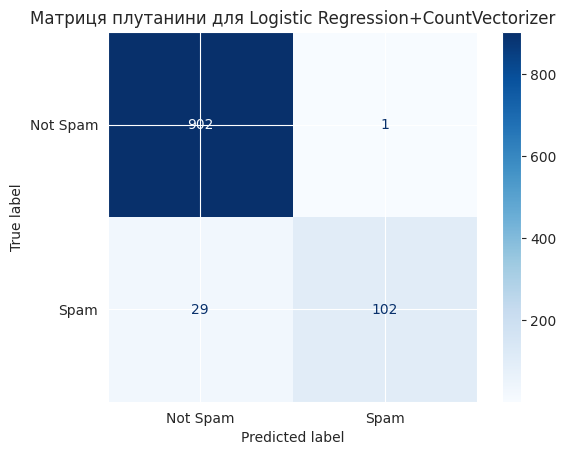

In [62]:
cm = confusion_matrix(y_test, y_pred_test, labels=best_estimator.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])

plt.figure(figsize=(6,6))
disp_cm.plot(cmap=plt.cm.Blues)
plt.title(f'Матриця плутанини для {best_model_name}')
plt.show()

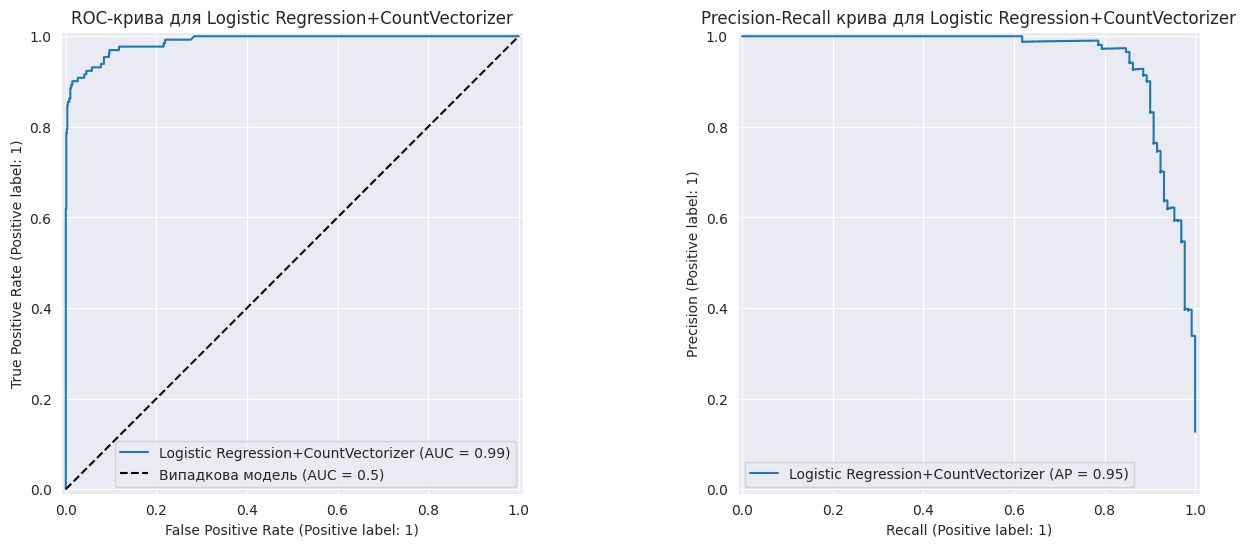

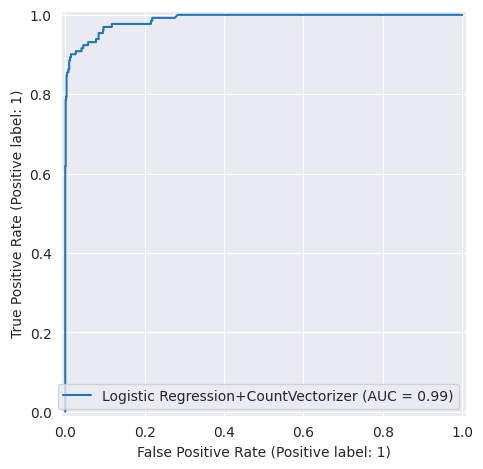

In [63]:
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
roc_display = RocCurveDisplay.from_estimator(best_estimator, X_test, y_test, name=best_model_name)
roc_display.plot(ax=axes[0])
axes[0].plot([0, 1], [0, 1], 'k--', label='Випадкова модель (AUC = 0.5)') # Допоміжна лінія
axes[0].set_title(f'ROC-крива для {best_model_name}')
axes[0].legend()

PrecisionRecallDisplay.from_estimator(best_estimator, X_test, y_test, name=best_model_name, ax=axes[1])
axes[1].set_title(f'Precision-Recall крива для {best_model_name}')

plt.tight_layout()
plt.show()


In [64]:
all_model_metrics_test = {}

for name, data in results.items():
    model = data['best_estimator'] # Найкращий естімейтор з GridSearch для цієї моделі
    y_p_test = model.predict(X_test)
    y_p_proba_test = model.predict_proba(X_test)[:, 1]

    all_model_metrics_test[name] = {
        'f1_spam': f1_score(y_test, y_p_test, pos_label=1),
        'roc_auc': roc_auc_score(y_test, y_p_proba_test),
        'recall_spam': classification_report(y_test, y_p_test, output_dict=True)['1']['recall'],
        'precision_spam': classification_report(y_test, y_p_test, output_dict=True)['1']['precision']
    }

metrics_df = pd.DataFrame(all_model_metrics_test).T
print("\nПорівняння моделей на тестовому наборі:")
print(metrics_df)


Порівняння моделей на тестовому наборі:
                                      f1_spam   roc_auc  recall_spam  \
Logistic Regression+TfidfVectorizer  0.846715  0.984898     0.885496   
Logistic Regression+CountVectorizer  0.871795  0.988102     0.778626   

                                     precision_spam  
Logistic Regression+TfidfVectorizer        0.811189  
Logistic Regression+CountVectorizer        0.990291  


In [65]:
from gensim.models.fasttext import load_facebook_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

In [66]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# !gunzip cc.en.300.bin.gz

In [66]:
# --- 1. Завантаження моделі ---
model = load_facebook_model("cc.en.300.bin")  # або cc.uk.300.bin для української

In [67]:
# --- 2. Функція перетворення тексту у вектор ---
def get_text_vector(text: str) -> np.ndarray:
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [68]:
# --- 4. Перетворення текстів на вектори ---
X_train_vectors = np.vstack([get_text_vector(text) for text in X_train['message_normalized']])
X_test_vectors  = np.vstack([get_text_vector(text) for text in X_test['message_normalized']])

# --- 5. Навчання моделі ---
# clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42, C=0.1)
# clf.fit(X_train_vectors, y_train)

from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(X_train_vectors, y_train)

# --- 6. Оцінка ---
y_pred = clf.predict(X_test_vectors)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       903
           1       0.93      0.82      0.87       131

    accuracy                           0.97      1034
   macro avg       0.95      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034



## 7. Аналіз та інтерпретація результатів

### Найкраща модель

Найкращий результат у задачі класифікації спаму показала модель Logistic Regression з CountVectorizer. Вона досягла найвищого f1-score для класу "спам" та високого ROC AUC (0.988).

### Порівняння моделей

Під час експериментів я протестував кілька поєднань:

- Logistic Regression + TfidfVectorizer
- Logistic Regression + CountVectorizer
- Logistic Regression + FastText
- FastText + XGBoost

### Проблеми і спроби під час навчання

На етапі тестування Logistic Regression з CountVectorizer та TfidfVectorizer основною проблемою було перенавчання. Значення параметра регуляризації `C` довелось суттєво зменшити до 0.1, щоб уникнути перенавчання моделі та покращити узагальнення.

Використання Logistic Regression з FastText показало дуже низьку якість класифікації. Модель виявляла спам (високий recall), але плутала його з не-спамом (низький precision). Причиною є те, що логістична регресія є лінійною моделлю і не в змозі витягнути складні залежності зі смислових векторів.

Для покращення якості я замінив Logistic Regression на XGBoost, який краще вловлює взаємодії між ознаками. Це дало набагато кращий результат, близький до CountVectorizer.

### Висновки

У цій задачі специфіка даних відіграє ключову роль. Спам-повідомлення зазвичай містять шаблонні слова-маркери, які повторюються в однакових або схожих комбінаціях. Тому прості моделі на кшталт Logistic Regression з CountVectorizer демонструють чудові результати, оскільки добре вловлюють ці патерни.

Однак у задачах з більшими наборами даних, де спам повідомлення більш різноманітні, FastText у поєднанні з нелінійною моделлю (наприклад, XGBoost) може мати перевагу завдяки своїй здатності узагальнювати значення слів і працювати з новими словами.

Також під час EDA була помічена певна кореляція довжини повідомлень і їх типу. Є доцільним ввести
 додаткову ознаку довжина текста. Це повинно покращити результати ще більше.
